# NLP With Hotel Review Part 2
## Submitted by Russ Kibat | October 2, 2022  

-----

## Setting up the notebook reviewing the dataset
### Libraries 

In [1]:
# Import Libraries 

# data wrangling 
import pandas as pd # dataframe manipulation 
import numpy as np # dependancy for pyplot
import matplotlib.pyplot as plt # create visualizations
import seaborn as sns
from time import time # used to measure run times 
import re # regular expressions 

from sklearn.decomposition import PCA # principal component analysis 
from sklearn.model_selection import train_test_split #data preparation 
from sklearn.preprocessing import StandardScaler # data scaling
from sklearn.metrics import accuracy_score # scoring
from sklearn.model_selection import cross_val_score # scoring
from sklearn.metrics import plot_confusion_matrix # scoring
from sklearn.metrics import classification_report #scoring

# models
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier



In [2]:
# Load data
test_df = pd.read_csv('data/clean_test_dataframe.csv')
train_df = pd.read_csv('data/clean_train_dataframe.csv')

In [3]:
# Check the size of the dataframes
print(f'Test data set shape: {test_df.shape[0]} rows {test_df.shape[1]} columns')
print(f'Train data set shape: {train_df.shape[0]} rows {train_df.shape[1]} columns')


Test data set shape: 4267 rows 2744 columns
Train data set shape: 12798 rows 2744 columns


### Data Review

In [4]:
# take a look all of the columns to get a feel of what the bulk of them are

test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Columns: 2744 entries, Additional_Number_of_Scoring to rating
dtypes: float64(3), int64(2741)
memory usage: 89.3 MB


In [5]:
# Check how many columns are related to hotel names, positive review words, and negative review words

# Set up the column prefixes to count and a counter
regex_list = ['^Hotel_Name_', '^p_', '^n_']
dummy_col = 0 

# check the list of columns for the prefixes counts and print the results 

for i in regex_list:
    r = re.compile(i)
    temp_list = list(filter(r.match,test_df.columns))
    dummy_col += len(temp_list)
    print(f'There are {len(temp_list)} columns that start with {i}')

print(f'There are {test_df.shape[1] - dummy_col} other columns')

There are 396 columns that start with ^Hotel_Name_
There are 983 columns that start with ^p_
There are 1343 columns that start with ^n_
There are 22 other columns


In [6]:
#next step is to set up x/y test and train DFs
X_train = train_df.drop('rating', axis=1)
X_test = test_df.drop('rating', axis=1)
y_train = train_df['rating']
y_test = test_df['rating']


In [7]:
print(f'Test data set shape: {test_df.shape[0]} rows {test_df.shape[1]} columns')
print(f'Train data set shape: {train_df.shape[0]} rows {train_df.shape[1]} columns')
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\
        \ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

Test data set shape: 4267 rows 2744 columns
Train data set shape: 12798 rows 2744 columns
X_train shape: (12798, 2743)
X_test shape: (4267, 2743)        
y_train shape: (12798,)
y_test shape: (4267,)


The updated data set contains about 17,000 rows with 25% of them being reserved for testing models. There are 2744 columns which is a huge expansion to the feature set. To get an understanding of what all those columns were I looked at the `.info()` listing and noticed that many columns from the original set are present. The expansion was from encoding tags, hotel names, positive review keywords and negative review key words. Using regular expressions I was able to find that there are approx.:  400 Hotels, 1000 positive review keywords, and 1350 negative review keywords. 

The final step of preparation was to create X and y dataframes from the test and train data files. As directed, 'Rating' was separated as a target variable. 


## 1 Employ a Linear Classifer on this dataset

a. Fit a logisitic regression model to this data with the solver set to lbfgs. What is the accuracy score on the test set?

b. What are the 20 words most predictive of a good review (from the positive review column)? What are the 20 words most predictive with a bad review (from the negative review column)? Use the regression coefficients to answer this question

c. Reduce the dimensionality of the dataset using PCA, what is the relationship between the number of dimensions and run-time for a logistic regression?

d. List one advantage and one disadvantage of dimensionality reduction.

### 1 a.

Setting up a basic model yielded a result of 73.3% accuracy. I added the `max_iter` parameter to ensure the logsitic regression would coverge. With so many variables scaling did not help the model coverge in the standard 100 iterations. I got good results after 250 iterations, but other versions of this model take more so I went with 1,000. 

In [8]:
# create scaled versions of the test and train dataframes
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)

In [9]:
# instantiate the model
# use lbfgs solver as directed, 1000 iterations to ensure the model converges
logistic_regression_model = LogisticRegression(solver='lbfgs', max_iter=1000)

# fit the model
logistic_regression_model.fit(X_train_ss, y_train)

LogisticRegression(max_iter=1000)

In [10]:
# Calculate the score and display it

score = logistic_regression_model.score(X_test_ss,y_test)
print(f'The score on the test set is {score*100:.1f}%')

The score on the test set is 73.3%


### 1 b.

Now that I have the the fitted model I can extract the list of coefficients and columns they are associated with. Taking a look at the lists and associated coefficients I can see that positive words tend to more impact on the model. 

In [11]:

# Set up a dataframe consisting of the coefficient of the model and the list of columns 

coefficient_df  = pd.DataFrame(logistic_regression_model.coef_).T
cols = pd.DataFrame(X_test.columns)

coefficient_df = pd.concat([coefficient_df,cols], axis = 1)
coefficient_df.set_axis(['coef','column'], axis=1, inplace=True)

# create smaller dataframes consisting of just positive review words and negative review words

p_df = coefficient_df[coefficient_df['column'].str.startswith('p_')]
n_df = coefficient_df[coefficient_df['column'].str.startswith('n_')]

# sort these columns and display top 20 words by coefficient.  
print('Top 20 Positive review words: ')
display(p_df.sort_values('coef', ascending=False).head(20))

print('Top 20 negative review words: ')
display(n_df.sort_values('coef', ascending=False).head(20))



Top 20 Positive review words: 


,coef,column
812,0.544474,p_gift
733,0.517316,p_excellent
880,0.450513,p_incredible
731,0.401304,p_exceed
874,0.398645,p_impeccable
728,0.374315,p_everything
829,0.350164,p_hair
822,0.348846,p_great
1242,0.348544,p_staff
664,0.337498,p_deluxe


Top 20 negative review words: 


,coef,column
2027,0.706545,n_inn
2208,0.360512,n_nothing
1980,0.351926,n_height
2637,0.341929,n_tricky
1725,0.326120,n_criticism
2728,0.315765,n_wonderful
1521,0.249176,n_assume
1678,0.241560,n_complain
2042,0.238234,n_join
1799,0.220748,n_drawer


### 1 c.

Using PCA and reducing the number of dimenensions did improve the model by 3%. This is an improvement of the first model, however there is still work to do.

Using `%timeit` I can see there is an order of magnitude difference between fitting a model to the full PCA set vs the 6 dimension set. 

In [12]:
# create PCA object
log_PCA = PCA()

# fit PCA to our data
log_PCA.fit(X_train_ss)

# transform the train and test data
X_train_ss_PCA = log_PCA.transform(X_train_ss)
X_test_ss_PCA = log_PCA.transform(X_test_ss)

In [13]:
# look at the shape of the PCA data
X_train_ss_PCA.shape

(12798, 2743)

In [14]:
# look at the variance explained by the first 10 most impactful features
for i in range(10):
    print(f'PCA feature #{i+1} var ratio: {log_PCA.explained_variance_ratio_[i]}')

# look at the variance explained by the last 10 most impactful features
for i in range(10):
    print(f'PCA feature #{-i} var ratio: {log_PCA.explained_variance_ratio_[-i]}')

# with over 2000 features it it makes sense that less each contributes < 1%


PCA feature #1 var ratio: 0.007637859215482228
PCA feature #2 var ratio: 0.004727197738142273
PCA feature #3 var ratio: 0.0021802390151672534
PCA feature #4 var ratio: 0.001960084867135508
PCA feature #5 var ratio: 0.0019249941981280033
PCA feature #6 var ratio: 0.0017158766635731037
PCA feature #7 var ratio: 0.0016899621491484448
PCA feature #8 var ratio: 0.0016589648703314523
PCA feature #9 var ratio: 0.0016107487339177213
PCA feature #10 var ratio: 0.001576439059399313
PCA feature #0 var ratio: 0.007637859215482228
PCA feature #-1 var ratio: 5.691169061098283e-37
PCA feature #-2 var ratio: 1.6093837478622824e-36
PCA feature #-3 var ratio: 3.132638814409508e-36
PCA feature #-4 var ratio: 4.432006586156138e-36
PCA feature #-5 var ratio: 6.248977796351376e-36
PCA feature #-6 var ratio: 1.3445946980485758e-35
PCA feature #-7 var ratio: 1.6918929449174655e-35
PCA feature #-8 var ratio: 1.8554423987425492e-35
PCA feature #-9 var ratio: 1.9447051737277108e-35


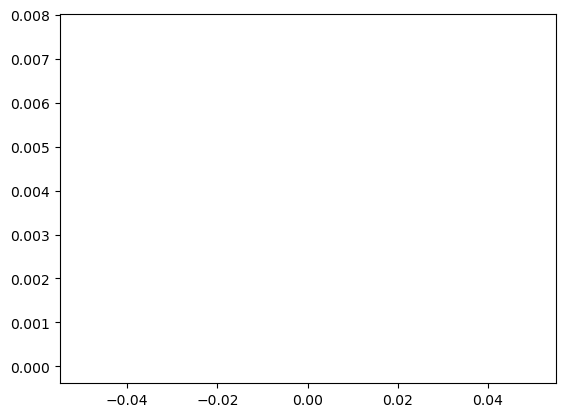

In [18]:
# look for a good number of PCs
plt.figure()
plt.plot([log_PCA.explained_variance_ratio_])
plt.show()

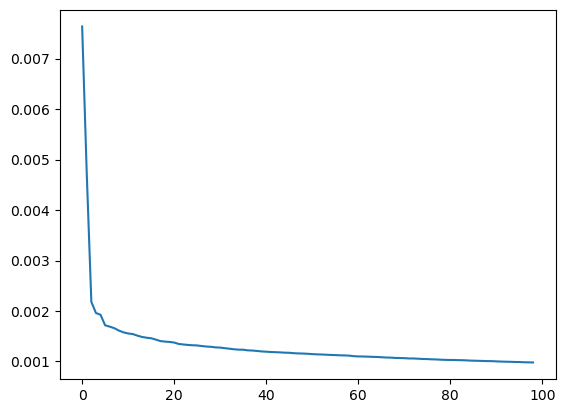

In [19]:
plt.figure()
plt.plot(log_PCA.explained_variance_ratio_[0:99])
plt.show()

#the elbow is less than 20, enhance!

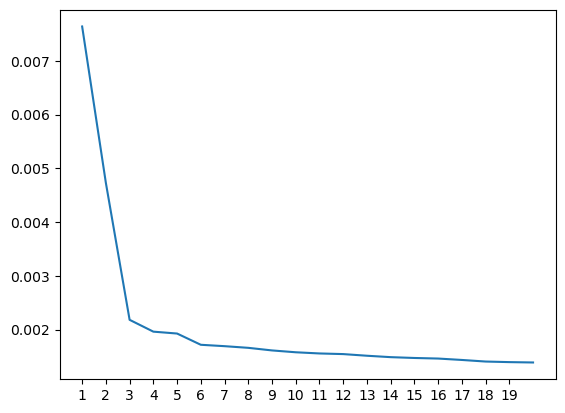

In [20]:
plt.figure()
plt.plot(range(1,21),log_PCA.explained_variance_ratio_[0:20])
plt.xticks(range(1,20,1))
plt.show()

#This indicates the I should use 6 components 


In [22]:
# fit the data using a 6 component PCA object

log_PCA_6 = PCA(n_components=20)
log_PCA_6.fit(X_train_ss)

# transform the train and test data
X_train_ss_PCA_6 = log_PCA_6.transform(X_train_ss)
X_test_ss_PCA_6 = log_PCA_6.transform(X_test_ss)


In [23]:
# build a logsitic regression model to this data

my_logreg_PCA_6 = LogisticRegression(solver='lbfgs', max_iter=1000)
my_logreg_PCA_6.fit(X_train_ss_PCA_6,y_train)
my_logreg_PCA_6.score(X_test_ss_PCA_6,y_test)

# we picked up 3% 




0.7698617295523787

In [24]:
%%timeit
my_logreg_PCA_6.fit(X_train_ss_PCA_6,y_train)

10.9 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
my_logreg_PCA = LogisticRegression(solver='lbfgs',max_iter=1000)



In [26]:
%%timeit
my_logreg_PCA.fit(X_train_ss_PCA,y_train)

5.12 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 1.d

One advantage of using PCA is you can reduce the number of features in your dataset without losing information. This saves time training your models without a loss of infromation supplied to them. In this case reducing the dimensions along with PCA imrpoved the accuracy score. 

The disadvantage is in understanding and interpreting the results. Once the data is transformed using PCA the features are combined so it is difficult to tell which ones are impacting results. This might be okay if you a trying to opitimize performnace of a model rather than using a model to explain which features impact the results. 


## 2 Employ a K- Nearest Neighbor classifier on the dataset.

Fit a KNN model to this data. What is the accuracy score on the test set?

KNN is a computationally expensive model. Reduce the number of observations (data points) in the dataset. What is the relationship between the number of observations and run-time for KNN?

List one advantage and one disadvantage of reducing the number of observations.

Use the dataset to find an optimal value for K in the KNN algorithm. You will need to split your dataset into train and validation sets.

What is the issue with splitting the data into train and validation sets after performing vectorization?



### 2 a

Running the test of scaled data yielded a score of 57%



In [27]:
# fit a KNN model and find the accuract score

KNN_NLP = KNeighborsClassifier()
KNN_NLP.fit(X_train_ss, y_train)

KNN_test = KNN_NLP.predict(X_test)
KNN_accuracy = accuracy_score(KNN_test, y_test)


c:\Users\russk\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [28]:
print(KNN_accuracy)

0.5753456761190532


### 2b 2c

Reducing the number of obervations in the model leads to a faster run time. This weakens the model by increasting the chance you will create an overfitted model that will perform worse overall


In [29]:
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_train, y_train, test_size=0.8, random_state=1)

In [53]:
## all data 454 ms/loop
## 80% data 348 ms/loop
## 60% data 256 ms/loop
## 40% data 189 ms/loop
## 20% data 87 ms/loop

## reducing the number of obervations in the model leads to a faster run time. This weakens the model by increasting the chance you will create an overfitted model that will perform worse overall



In [30]:

%%timeit
KNN_NLP.fit(X_train_reduced, y_train_reduced)

85.4 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 2d

18 nearest neighbors would be the optimal paramater for this model.

### 2e
Spliting data into test/train/validation sets before vectorizing raises the potential of creating different features in each set. The result will be models that are overfitted to the training set.


In [31]:
k_list =np.arange(1,50,1)
score_list = []

X_train_knn, X_validiation_knn, y_train_knn, y_validiation_knn = train_test_split(X_train_ss, y_train, test_size=0.2, random_state=1)

for k in k_list:
    KNN_NLP = KNeighborsClassifier(n_neighbors=k)
    KNN_NLP.fit(X_train_knn, y_train_knn)
    KNN_test = KNN_NLP.predict(X_validiation_knn)
    KNN_accuracy = accuracy_score(KNN_test, y_validiation_knn)
    score_list.append(KNN_accuracy)
   

    

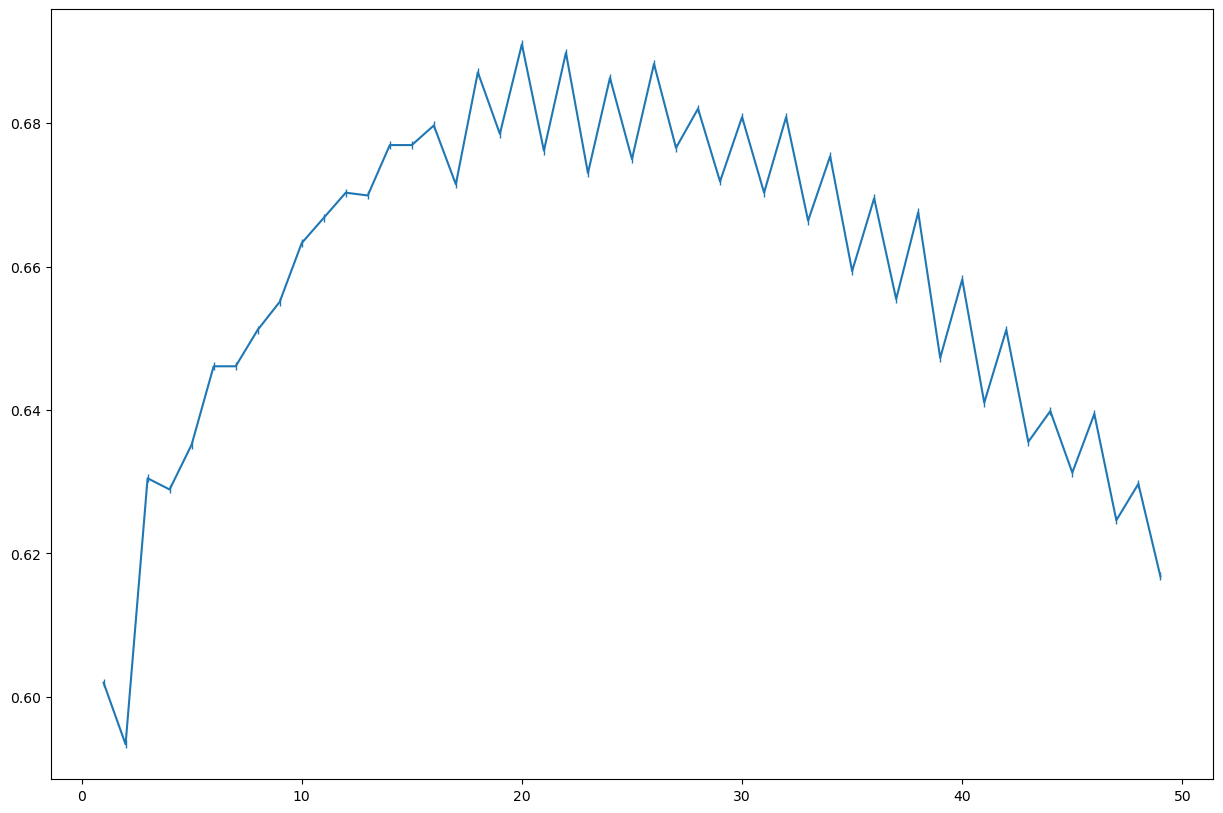

In [32]:
plt.figure(figsize=(15,10))
plt.plot(k_list, score_list, marker='|')
plt.show()

## 3 Employ a Decision Tree classifier on this dataset


Employ a Decision Tree classifier on this dataset:

Fit a decision tree model to this data. What is the accuracy score on the test set?

Use the data set (or a subsample) to find an optimal value for the maximum depth of the decision tree. You will need to split your data set into train and validation.

Provide two advantages of decision trees over KNN. Provide two weaknesses of decision trees (classification or regression trees)



### 3a

The base model for decision tree yielded a 69.7% result


In [33]:
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [34]:
DT_model.score(X_test, y_test)

0.701663932505273

### 3b

The optimal depth for a the decision tree on this dataset is 8. That yields a 74% accuracy rate on the validation set and a 74.5% on the test data.

Process Complete


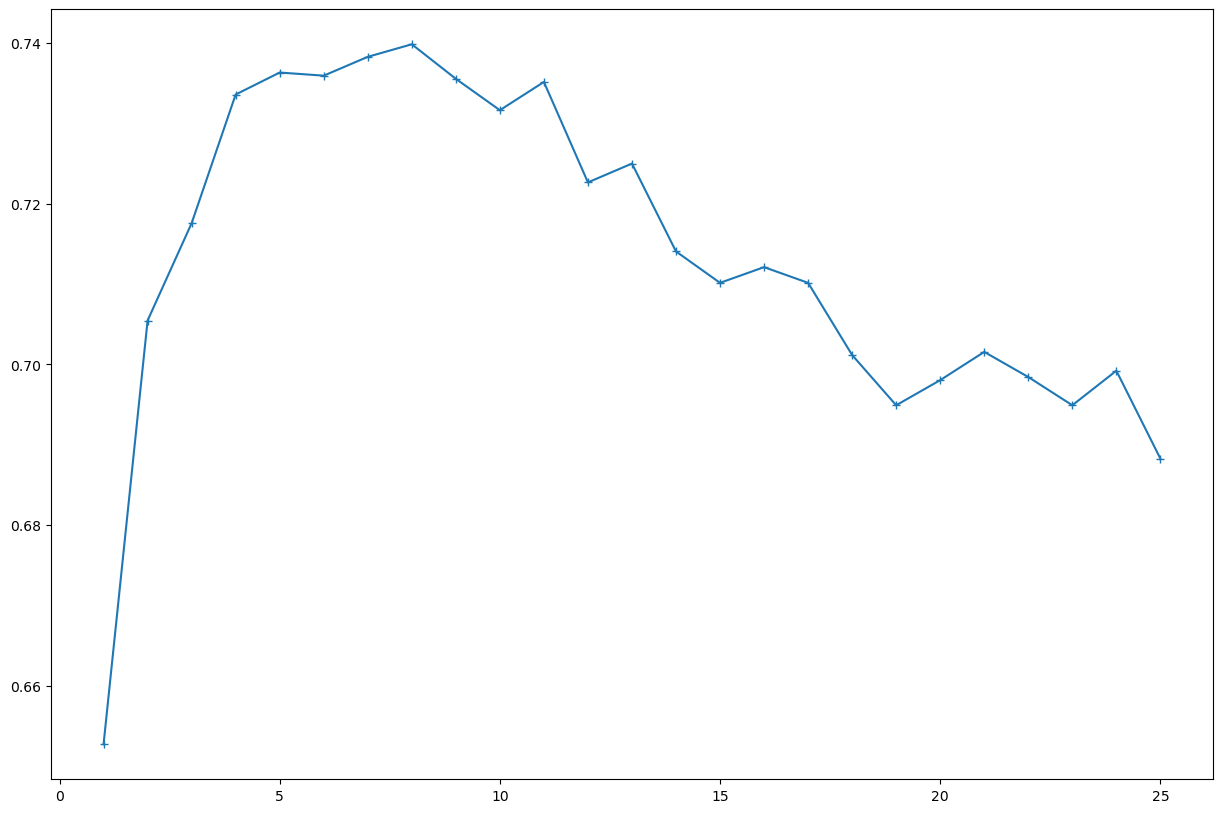

In [35]:
depth_list = np.arange(1,26)
score_list = []

X_train_DT, X_validiation_DT, y_train_DT, y_validiation_DT = train_test_split(X_train, y_train, test_size=0.2, random_state=1)


for d in depth_list:
    DT_model = DecisionTreeClassifier(max_depth=d)
    DT_model.fit(X_train_DT, y_train_DT)
    DT_score = DT_model.score(X_validiation_DT,y_validiation_DT)
    score_list.append(DT_score)
    
print('Process Complete')

plt.figure(figsize=(15,10))
plt.plot(depth_list, score_list, marker='+')
plt.show()

results = pd.DataFrame([depth_list,score_list]).T


In [36]:
results = pd.DataFrame([depth_list,score_list]).T

results.sort_values(by=1, ascending=False).head(1)

,0,1
7,8.0,0.739844


In [37]:
DT_model = DecisionTreeClassifier(max_depth=8)
DT_model.fit(X_train,y_train)
DT_model.score(X_test, y_test)

0.7464260604640263

## 4

What is the purpose of the validation set, i.e., how is it different than the test set?

The validation sets are used for tuning a model. It is a subset of the training data where test data is separated before the training process. By keeping validation data separate from training data we can tune the model without bringing in bias from the test set. It also ensures that the test data is unseen by the model (and the data scientist!) This is strengthend with cross validation is used since there are multiple samples of the training data being tested.

## 5 


Re-run a decision tree or logistic regression on the data again:

Perform a 5-fold cross validation to optimize the hyperparameters of your model.
 What does your confusion matrix look like for your best model on the test set?



### 5 a

Using a 5-fold cross validation on the logisitic regression model pointed to 0.001 being the optimal value for the l2 parameter C. 

In [38]:
cv_score_list = []
C_range = [.00001,.0001,.001,.1,1,10,100,1000,10000]

for c in C_range:
    log_model_5 = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2', C=c)

    score = np.mean(cross_val_score(log_model_5,X_train_ss,y_train, cv=5))

    cv_score_list.append(score)

    print(f'{c} loop complete')

1e-05 loop complete
0.0001 loop complete
0.001 loop complete
0.1 loop complete
1 loop complete
10 loop complete
100 loop complete
1000 loop complete
10000 loop complete


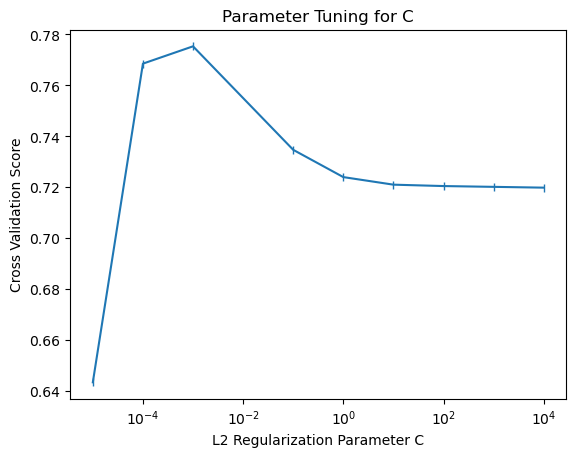

In [39]:
plt.figure()
plt.plot(C_range, cv_score_list, marker='|')
plt.xscale("log")
plt.title('Parameter Tuning for C')
plt.xlabel('L2 Regularization Parameter C')
plt.ylabel('Cross Validation Score')
plt.show()



In [40]:
results = pd.DataFrame([C_range,cv_score_list]).T
results.sort_values(by=1, ascending=False).head(1)

,0,1
2,0.001,0.775277


In [41]:
log_model_5b = LogisticRegression(solver='lbfgs', max_iter=250, penalty='l2', C=.001)
log_model_5b.fit(X_train_ss, y_train)

LogisticRegression(C=0.001, max_iter=250)

### 5b

This model, now tuned, has an acurracy of 78% making it the best version of the regression model yet. The confusion matrix shows about 1300 bad reviews correctly labeled and 2000 good reviews correctly labeled. What's interesting is that the number of of false positives and false negatives are similar and the model isn't tedning to misclassify in one direction or the other. To me that indicates that our model isn't biased because the edge cases are evenly split. 

c:\Users\russk\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


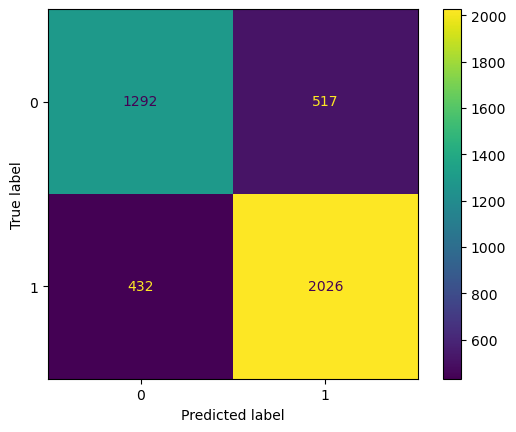

In [42]:
plot_confusion_matrix(log_model_5b, X_test_ss, y_test)

In [43]:
# other metrics

log_model_5b_predictions = log_model_5b.predict(X_test_ss)
report_initial = classification_report(y_test, log_model_5b_predictions)
print(report_initial)

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1809
           1       0.80      0.82      0.81      2458

    accuracy                           0.78      4267
   macro avg       0.77      0.77      0.77      4267
weighted avg       0.78      0.78      0.78      4267

